In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import argparse
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # Dodane dla wizualizacji 3D
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

C:\Users\karol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

def adding_to_graph(clauses):
    G = nx.Graph()
    for clause in clauses:
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))  # Dodanie krawędzi między zmiennymi w tej samej klauzuli
    return G

def visualize_graph(G):
    pos = nx.spring_layout(G)  # Ustalenie układu wizualizacji
    nx.draw(G, pos, with_labels=True, node_size=500)
    plt.show()

def generate_node_embeddings(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=40, num_walks=40, workers=4)
    print("Generating node embeddings...")
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    # node2vec.graph.save("graph.kg")
    return model

def visualize_node_embeddings(model):
    node_ids = model.wv.index_to_key
    # print(node_ids)
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(node_embeddings)

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    for i, txt in enumerate(node_ids):
        plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 2), textcoords='offset points')
    plt.title('Node Embeddings Visualization (2D)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()


In [3]:
def visualize_node_embeddings_with_edges(model, graph):
    node_ids = list(graph.nodes)
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=3)
    embeddings_3d = pca.fit_transform(node_embeddings)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Dodanie węzłów
    ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], alpha=0.7)

    # Dodanie krawędzi
    for edge in graph.edges():
        node1, node2 = edge
        idx1, idx2 = node_ids.index(node1), node_ids.index(node2)
        ax.plot([embeddings_3d[idx1, 0], embeddings_3d[idx2, 0]],
                [embeddings_3d[idx1, 1], embeddings_3d[idx2, 1]],
                [embeddings_3d[idx1, 2], embeddings_3d[idx2, 2]], color='gray', alpha=0.5)

    # Dodanie etykiet
    for i, txt in enumerate(node_ids):
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], txt, fontsize=8)

    ax.set_title('Node Embeddings Visualization (3D)')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

In [4]:
def cluster_and_visualize_node_embeddings(model, graph, num_clusters=3):
    node_ids = list(graph.nodes)
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(node_embeddings)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_2d)

    plt.figure(figsize=(10, 8))
    for i in range(num_clusters):
        cluster_points = embeddings_2d[cluster_labels == i] # Pobranie punktów należących do danego klastra
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}') # Dodanie punktów do wykresu dla danego klastra

    for i, txt in enumerate(node_ids):  # Dodanie etykiet do punktów na wykresie
        plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(2, 2), textcoords='offset points', fontsize=7)

    plt.title(f'Node Embeddings Clustering (K-means, {num_clusters} clusters)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()


4614


Computing transition probabilities:   0%|          | 8/4614 [00:00<02:08, 35.98it/s]

Computing transition probabilities: 100%|██████████| 4614/4614 [00:04<00:00, 1087.47it/s]


Generating node embeddings...
Jestem przed wizualizacją


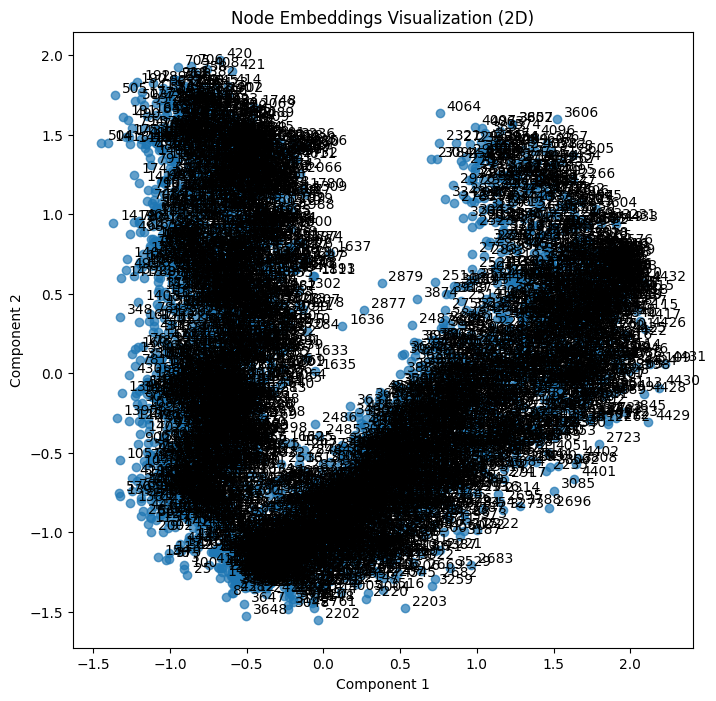

C:\Users\karol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


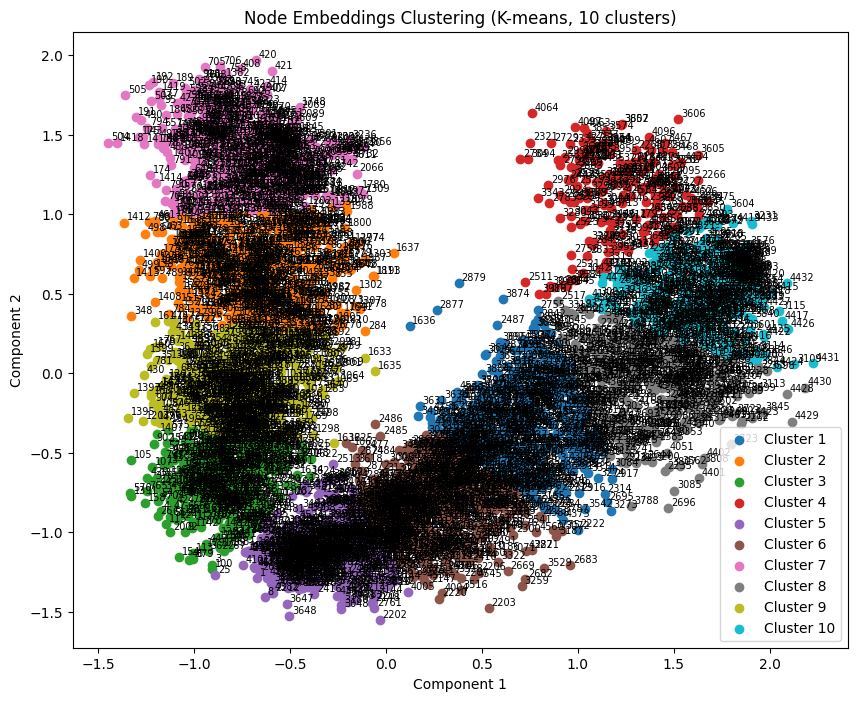

In [5]:
# nazwa = "DIMACS_files/turbo_easy/example_2.cnf"
nazwa = "DIMACS_files/medium/unsat/Analiza1-AProVE07-08.cnf"


num_vars, clauses = read_dimacs_cnf(nazwa)
G = adding_to_graph(clauses)
print(num_vars)
# print(clauses.shape)
# visualize_graph(G)
node_embeddings_model = generate_node_embeddings(G)
# valMAX=0
# nodeMax = 0
# diff_node = 0
# for node in node_embeddings_model.wv.index_to_key:
#     node_sim = node_embeddings_model.wv.most_similar(str(node))[0][0]
#     val = node_embeddings_model.wv.most_similar(str(node))[0][1]
#     # print(node, node_sim, val)
#     if val > valMAX:
#         valMAX = val
#         nodeMax = node_sim
#         diff_node = node
print("Jestem przed wizualizacją")
# print(node_embeddings_model.wv.most_similar('77'))
# print(diff_node, nodeMax, valMAX)
visualize_node_embeddings(node_embeddings_model)
# visualize_node_embeddings_with_edges(node_embeddings_model, G)
cluster_and_visualize_node_embeddings(node_embeddings_model, G, num_clusters=10)
